In [1]:
%load_ext tensorboard
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [2]:
file_url = "input_data.csv"
dataframe = pd.read_csv(file_url, dtype= {
'index': int,
'term' : str, 
'installment' : np.float32,
'emp_title' : 'str', 
'purpose' : 'str', 
'title' : 'str', 
'dti' : np.float32,
'collections_12_mths_ex_med' : np.float32,
'application_type' : 'str', 
'tot_coll_amt' : np.float32,
'tot_cur_bal' : np.float32,
'open_acc_6m' : np.float32,
'open_act_il' : np.float32,
'open_il_12m' : np.float32,
'open_il_24m' : np.float32,
'mths_since_rcnt_il' : np.float32,
'total_bal_il' : np.float32,
'open_rv_12m' : np.float32,
'open_rv_24m' : np.float32,
'max_bal_bc' : np.float32,
'all_util' : np.float32,
'inq_fi' : np.float32,
'total_cu_tl' : np.float32,
'inq_last_12m' : np.float32,
'avg_cur_bal' : np.float32,
'chargeoff_within_12_mths' : np.float32,
'mo_sin_old_rev_tl_op' : np.float32,
'mo_sin_rcnt_rev_tl_op' : np.float32,
'mo_sin_rcnt_tl' : np.float32,
'num_accts_ever_120_pd' : np.float32,
'num_actv_bc_tl' : np.float32,
'num_actv_rev_tl' : np.float32,
'num_bc_sats' : np.float32,
'num_bc_tl' : np.float32,
'num_il_tl' : np.float32,
'num_op_rev_tl' : np.float32,
'num_rev_accts' : np.float32,
'num_rev_tl_bal_gt_0' : np.float32,
'num_sats' : np.float32,
'num_tl_120dpd_2m' : np.float32,
'num_tl_30dpd' : np.float32,
'num_tl_90g_dpd_24m' : np.float32,
'num_tl_op_past_12m' : np.float32,
'pct_tl_nvr_dlq' : np.float32,
'pub_rec_bankruptcies' : np.float32,
'tax_liens' : np.float32,
'tot_hi_cred_lim' : np.float32,
'total_il_high_credit_limit' : np.float32,
'disbursement_method' : 'str', 
'is_risky' : np.int32,
    })
dataframe.set_index("index", inplace=True)
dataframe.dropna(inplace=True)
dataframe.reset_index(drop=True,inplace=True)

In [3]:
to_int_cols = ['chargeoff_within_12_mths', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'pub_rec_bankruptcies']
dataframe[to_int_cols] = dataframe[to_int_cols].astype(np.int32)

In [9]:
dataframe.groupby("purpose")["purpose"].count()

purpose
car                    13044
credit_card           263755
debt_consolidation    643226
educational                1
home_improvement       84892
house                   9011
major_purchase         28928
medical                16013
moving                  8732
other                  82523
renewable_energy         752
small_business         12370
vacation                9286
wedding                    5
Name: purpose, dtype: int64

In [4]:
dataframe.shape

(1172538, 49)

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172538 entries, 0 to 1172537
Data columns (total 49 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   term                        1172538 non-null  object 
 1   installment                 1172538 non-null  float32
 2   emp_title                   1172538 non-null  object 
 3   purpose                     1172538 non-null  object 
 4   title                       1172538 non-null  object 
 5   dti                         1172538 non-null  float32
 6   collections_12_mths_ex_med  1172538 non-null  float32
 7   application_type            1172538 non-null  object 
 8   tot_coll_amt                1172538 non-null  float32
 9   tot_cur_bal                 1172538 non-null  float32
 10  open_acc_6m                 1172538 non-null  float32
 11  open_act_il                 1172538 non-null  float32
 12  open_il_12m                 1172538 non-null  float32
 1

In [6]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 938030 samples for training and 234508 for validation


In [7]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("is_risky")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [8]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'term': <tf.Tensor: shape=(), dtype=string, numpy=b' 36 months'>, 'installment': <tf.Tensor: shape=(), dtype=float32, numpy=547.98>, 'emp_title': <tf.Tensor: shape=(), dtype=string, numpy=b'Branch Supervisor'>, 'purpose': <tf.Tensor: shape=(), dtype=string, numpy=b'debt_consolidation'>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Debt consolidation'>, 'dti': <tf.Tensor: shape=(), dtype=float32, numpy=26.15>, 'collections_12_mths_ex_med': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'application_type': <tf.Tensor: shape=(), dtype=string, numpy=b'Individual'>, 'tot_coll_amt': <tf.Tensor: shape=(), dtype=float32, numpy=46.0>, 'tot_cur_bal': <tf.Tensor: shape=(), dtype=float32, numpy=99033.0>, 'open_acc_6m': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'open_act_il': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, 'open_il_12m': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'open_il_24m': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'mths_since_rcnt_il': <t

In [9]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [10]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary") 

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature

In [19]:

#Categorical feature encoded as numeric
chargeoff_within_12_mths = keras.Input(shape=(1,),name="chargeoff_within_12_mths",dtype="int64")
num_tl_120dpd_2m = keras.Input(shape=(1,), name="num_tl_120dpd_2m", dtype="int64")
num_tl_30dpd = keras.Input(shape=(1,), name="num_tl_30dpd", dtype="int64")
pub_rec_bankruptcies = keras.Input(shape=(1,), name="pub_rec_bankruptcies", dtype="int64")



# Categorical feature encoded as string
application_type = keras.Input(shape=(1,), name="application_type", dtype="string")
disbursement_method = keras.Input(shape=(1,), name="disbursement_method", dtype="string")
emp_title = keras.Input(shape=(1,), name="emp_title", dtype="string")
purpose = keras.Input(shape=(1,), name="purpose", dtype="string")
term = keras.Input(shape=(1,), name="term", dtype="string")
title = keras.Input(shape=(1,), name="title", dtype="string")


# Numerical features
all_util = keras.Input(shape=(1,),name="all_util")
avg_cur_bal = keras.Input(shape=(1,), name="avg_cur_bal")
collections_12_mths_ex_med = keras.Input(shape=(1,), name="collections_12_mths_ex_med")
dti = keras.Input(shape=(1,), name="dti")
inq_fi = keras.Input(shape=(1,), name="inq_fi")
inq_last_12m = keras.Input(shape=(1,), name="inq_last_12m")
installment = keras.Input(shape=(1,), name="installment")
max_bal_bc = keras.Input(shape=(1,), name="max_bal_bc")
mo_sin_old_rev_tl_op = keras.Input(shape=(1,), name="mo_sin_old_rev_tl_op")
mo_sin_rcnt_rev_tl_op = keras.Input(shape=(1,), name="mo_sin_rcnt_rev_tl_op")
mo_sin_rcnt_tl = keras.Input(shape=(1,), name="mo_sin_rcnt_tl")
mths_since_rcnt_il = keras.Input(shape=(1,), name="mths_since_rcnt_il")
num_accts_ever_120_pd = keras.Input(shape=(1,), name="num_accts_ever_120_pd")
num_actv_bc_tl = keras.Input(shape=(1,), name="num_actv_bc_tl")
num_actv_rev_tl = keras.Input(shape=(1,), name="num_actv_rev_tl")
num_bc_sats = keras.Input(shape=(1,), name="num_bc_sats")
num_bc_tl = keras.Input(shape=(1,), name="num_bc_tl")
num_il_tl = keras.Input(shape=(1,), name="num_il_tl")
num_op_rev_tl = keras.Input(shape=(1,), name="num_op_rev_tl")
num_rev_accts = keras.Input(shape=(1,), name="num_rev_accts")
num_rev_tl_bal_gt_0 = keras.Input(shape=(1,), name="num_rev_tl_bal_gt_0")
num_sats = keras.Input(shape=(1,), name="num_sats")
num_tl_90g_dpd_24m = keras.Input(shape=(1,), name="num_tl_90g_dpd_24m")
num_tl_op_past_12m = keras.Input(shape=(1,), name="num_tl_op_past_12m")
open_acc_6m = keras.Input(shape=(1,), name="open_acc_6m")
open_act_il = keras.Input(shape=(1,), name="open_act_il")
open_il_12m = keras.Input(shape=(1,), name="open_il_12m")
open_il_24m = keras.Input(shape=(1,), name="open_il_24m")
open_rv_12m = keras.Input(shape=(1,), name="open_rv_12m")
open_rv_24m = keras.Input(shape=(1,), name="open_rv_24m")
pct_tl_nvr_dlq = keras.Input(shape=(1,), name="pct_tl_nvr_dlq")
tax_liens = keras.Input(shape=(1,), name="tax_liens")
tot_coll_amt = keras.Input(shape=(1,), name="tot_coll_amt")
tot_cur_bal = keras.Input(shape=(1,), name="tot_cur_bal")
tot_hi_cred_lim = keras.Input(shape=(1,), name="tot_hi_cred_lim")
total_bal_il = keras.Input(shape=(1,), name="total_bal_il")
total_cu_tl = keras.Input(shape=(1,), name="total_cu_tl")
total_il_high_credit_limit = keras.Input(shape=(1,), name="total_il_high_credit_limit")


#Categorical feature encoded as numeric
chargeoff_within_12_mths_encoded = encode_integer_categorical_feature(chargeoff_within_12_mths, "chargeoff_within_12_mths",train_ds)
num_tl_120dpd_2m_encoded = encode_integer_categorical_feature(num_tl_120dpd_2m, "num_tl_120dpd_2m", train_ds)
num_tl_30dpd_encoded = encode_integer_categorical_feature(num_tl_30dpd, "num_tl_30dpd", train_ds)
pub_rec_bankruptcies_encoded = encode_integer_categorical_feature(pub_rec_bankruptcies, "pub_rec_bankruptcies", train_ds)



# Categorical feature encoded as string
application_type_encoded = encode_string_categorical_feature(application_type, "application_type", train_ds)
disbursement_method_encoded = encode_string_categorical_feature(disbursement_method, "disbursement_method", train_ds)
emp_title_encoded = encode_string_categorical_feature(emp_title, "emp_title", train_ds)
purpose_encoded = encode_string_categorical_feature(purpose, "purpose", train_ds)
term_encoded = encode_string_categorical_feature(term, "term", train_ds)
title_encoded = encode_string_categorical_feature(title, "title", train_ds)


# Numerical features
all_util_encoded = encode_numerical_feature(all_util, "all_util", train_ds)
avg_cur_bal_encoded = encode_numerical_feature(avg_cur_bal, "avg_cur_bal", train_ds)
collections_12_mths_ex_med_encoded = encode_numerical_feature(collections_12_mths_ex_med, "collections_12_mths_ex_med", train_ds)
dti_encoded = encode_numerical_feature(dti, "dti", train_ds)
inq_fi_encoded = encode_numerical_feature(inq_fi, "inq_fi", train_ds)
inq_last_12m_encoded = encode_numerical_feature(inq_last_12m, "inq_last_12m", train_ds)
installment_encoded = encode_numerical_feature(installment, "installment", train_ds)
max_bal_bc_encoded = encode_numerical_feature(max_bal_bc, "max_bal_bc", train_ds)
mo_sin_old_rev_tl_op_encoded = encode_numerical_feature(mo_sin_old_rev_tl_op, "mo_sin_old_rev_tl_op", train_ds)
mo_sin_rcnt_rev_tl_op_encoded = encode_numerical_feature(mo_sin_rcnt_rev_tl_op, "mo_sin_rcnt_rev_tl_op", train_ds)
mo_sin_rcnt_tl_encoded = encode_numerical_feature(mo_sin_rcnt_tl, "mo_sin_rcnt_tl", train_ds)
mths_since_rcnt_il_encoded = encode_numerical_feature(mths_since_rcnt_il, "mths_since_rcnt_il", train_ds)
num_accts_ever_120_pd_encoded = encode_numerical_feature(num_accts_ever_120_pd, "num_accts_ever_120_pd", train_ds)
num_actv_bc_tl_encoded = encode_numerical_feature(num_actv_bc_tl, "num_actv_bc_tl", train_ds)
num_actv_rev_tl_encoded = encode_numerical_feature(num_actv_rev_tl, "num_actv_rev_tl", train_ds)
num_bc_sats_encoded = encode_numerical_feature(num_bc_sats, "num_bc_sats", train_ds)
num_bc_tl_encoded = encode_numerical_feature(num_bc_tl, "num_bc_tl", train_ds)
num_il_tl_encoded = encode_numerical_feature(num_il_tl, "num_il_tl", train_ds)
num_op_rev_tl_encoded = encode_numerical_feature(num_op_rev_tl, "num_op_rev_tl", train_ds)
num_rev_accts_encoded = encode_numerical_feature(num_rev_accts, "num_rev_accts", train_ds)
num_rev_tl_bal_gt_0_encoded = encode_numerical_feature(num_rev_tl_bal_gt_0, "num_rev_tl_bal_gt_0", train_ds)
num_sats_encoded = encode_numerical_feature(num_sats, "num_sats", train_ds)
num_tl_90g_dpd_24m_encoded = encode_numerical_feature(num_tl_90g_dpd_24m, "num_tl_90g_dpd_24m", train_ds)
num_tl_op_past_12m_encoded = encode_numerical_feature(num_tl_op_past_12m, "num_tl_op_past_12m", train_ds)
open_acc_6m_encoded = encode_numerical_feature(open_acc_6m, "open_acc_6m", train_ds)
open_act_il_encoded = encode_numerical_feature(open_act_il, "open_act_il", train_ds)
open_il_12m_encoded = encode_numerical_feature(open_il_12m, "open_il_12m", train_ds)
open_il_24m_encoded = encode_numerical_feature(open_il_24m, "open_il_24m", train_ds)
open_rv_12m_encoded = encode_numerical_feature(open_rv_12m, "open_rv_12m", train_ds)
open_rv_24m_encoded = encode_numerical_feature(open_rv_24m, "open_rv_24m", train_ds)
pct_tl_nvr_dlq_encoded = encode_numerical_feature(pct_tl_nvr_dlq, "pct_tl_nvr_dlq", train_ds)
tax_liens_encoded = encode_numerical_feature(tax_liens, "tax_liens", train_ds)
tot_coll_amt_encoded = encode_numerical_feature(tot_coll_amt, "tot_coll_amt", train_ds)
tot_cur_bal_encoded = encode_numerical_feature(tot_cur_bal, "tot_cur_bal", train_ds)
tot_hi_cred_lim_encoded = encode_numerical_feature(tot_hi_cred_lim, "tot_hi_cred_lim", train_ds)
total_bal_il_encoded = encode_numerical_feature(total_bal_il, "total_bal_il", train_ds)
total_cu_tl_encoded = encode_numerical_feature(total_cu_tl, "total_cu_tl", train_ds)
total_il_high_credit_limit_encoded = encode_numerical_feature(total_il_high_credit_limit, "total_il_high_credit_limit", train_ds)


KeyboardInterrupt: 

In [ ]:


all_inputs = [
     application_type,
#     chargeoff_within_12_mths,
#     emp_title,
#     inq_fi,
#     inq_last_12m,
#     mo_sin_old_rev_tl_op,
#     mo_sin_rcnt_rev_tl_op,
#     mo_sin_rcnt_tl,
#     mths_since_rcnt_il,
#     num_actv_bc_tl,
     num_tl_120dpd_2m,
#     num_tl_30dpd,
#     num_tl_90g_dpd_24m,
#     num_tl_op_past_12m,
#     open_act_il,
#     pub_rec_bankruptcies,
     term,
#     title,
#     total_cu_tl,
#     all_util,
     avg_cur_bal,
#     collections_12_mths_ex_med,
     dti,
     installment,
#     max_bal_bc,
#     num_accts_ever_120_pd,
#     num_actv_rev_tl,
#     num_bc_sats,
#     num_bc_tl,
#     num_il_tl,
#     num_op_rev_tl,
#     num_rev_accts,
#     num_rev_tl_bal_gt_0,
#     num_sats,
#     open_acc_6m,
#     open_il_12m,
#     open_il_24m,
#     open_rv_12m,
#     open_rv_24m,
#     pct_tl_nvr_dlq,
#     tax_liens,
#     tot_coll_amt,
#     tot_cur_bal,
#     tot_hi_cred_lim,
#     total_bal_il,
#     total_il_high_credit_limit,
#     disbursement_method,
     purpose,
]

all_features = layers.concatenate(
    [
     application_type_encoded,
#     chargeoff_within_12_mths_encoded,
#     emp_title_encoded,
#     inq_fi_encoded,
#     inq_last_12m_encoded,
#     mo_sin_old_rev_tl_op_encoded,
#     mo_sin_rcnt_rev_tl_op_encoded,
#     mo_sin_rcnt_tl_encoded,
#     mths_since_rcnt_il_encoded,
#     num_actv_bc_tl_encoded,
     num_tl_120dpd_2m_encoded,
#     num_tl_30dpd_encoded,
#     num_tl_90g_dpd_24m_encoded,
#     num_tl_op_past_12m_encoded,
#     open_act_il_encoded,
#     pub_rec_bankruptcies_encoded,
     term_encoded,
#     title_encoded,
#     total_cu_tl_encoded,
#     all_util_encoded,
     avg_cur_bal_encoded,
#     collections_12_mths_ex_med_encoded,
     dti_encoded,
     installment_encoded,
#     max_bal_bc_encoded,
#     num_accts_ever_120_pd_encoded,
#     num_actv_rev_tl_encoded,
#     num_bc_sats_encoded,
#     num_bc_tl_encoded,
#     num_il_tl_encoded,
#     num_op_rev_tl_encoded,
#     num_rev_accts_encoded,
#     num_rev_tl_bal_gt_0_encoded,
#     num_sats_encoded,
#     open_acc_6m_encoded,
#     open_il_12m_encoded,
#     open_il_24m_encoded,
#     open_rv_12m_encoded,
#     open_rv_24m_encoded,
#     pct_tl_nvr_dlq_encoded,
#     tax_liens_encoded,
#     tot_coll_amt_encoded,
#     tot_cur_bal_encoded,
#     tot_hi_cred_lim_encoded,
#     total_bal_il_encoded,
#     total_il_high_credit_limit_encoded,
#     disbursement_method_encoded,
     purpose_encoded,
    ]
)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
x = layers.Dense(15, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)

In [12]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

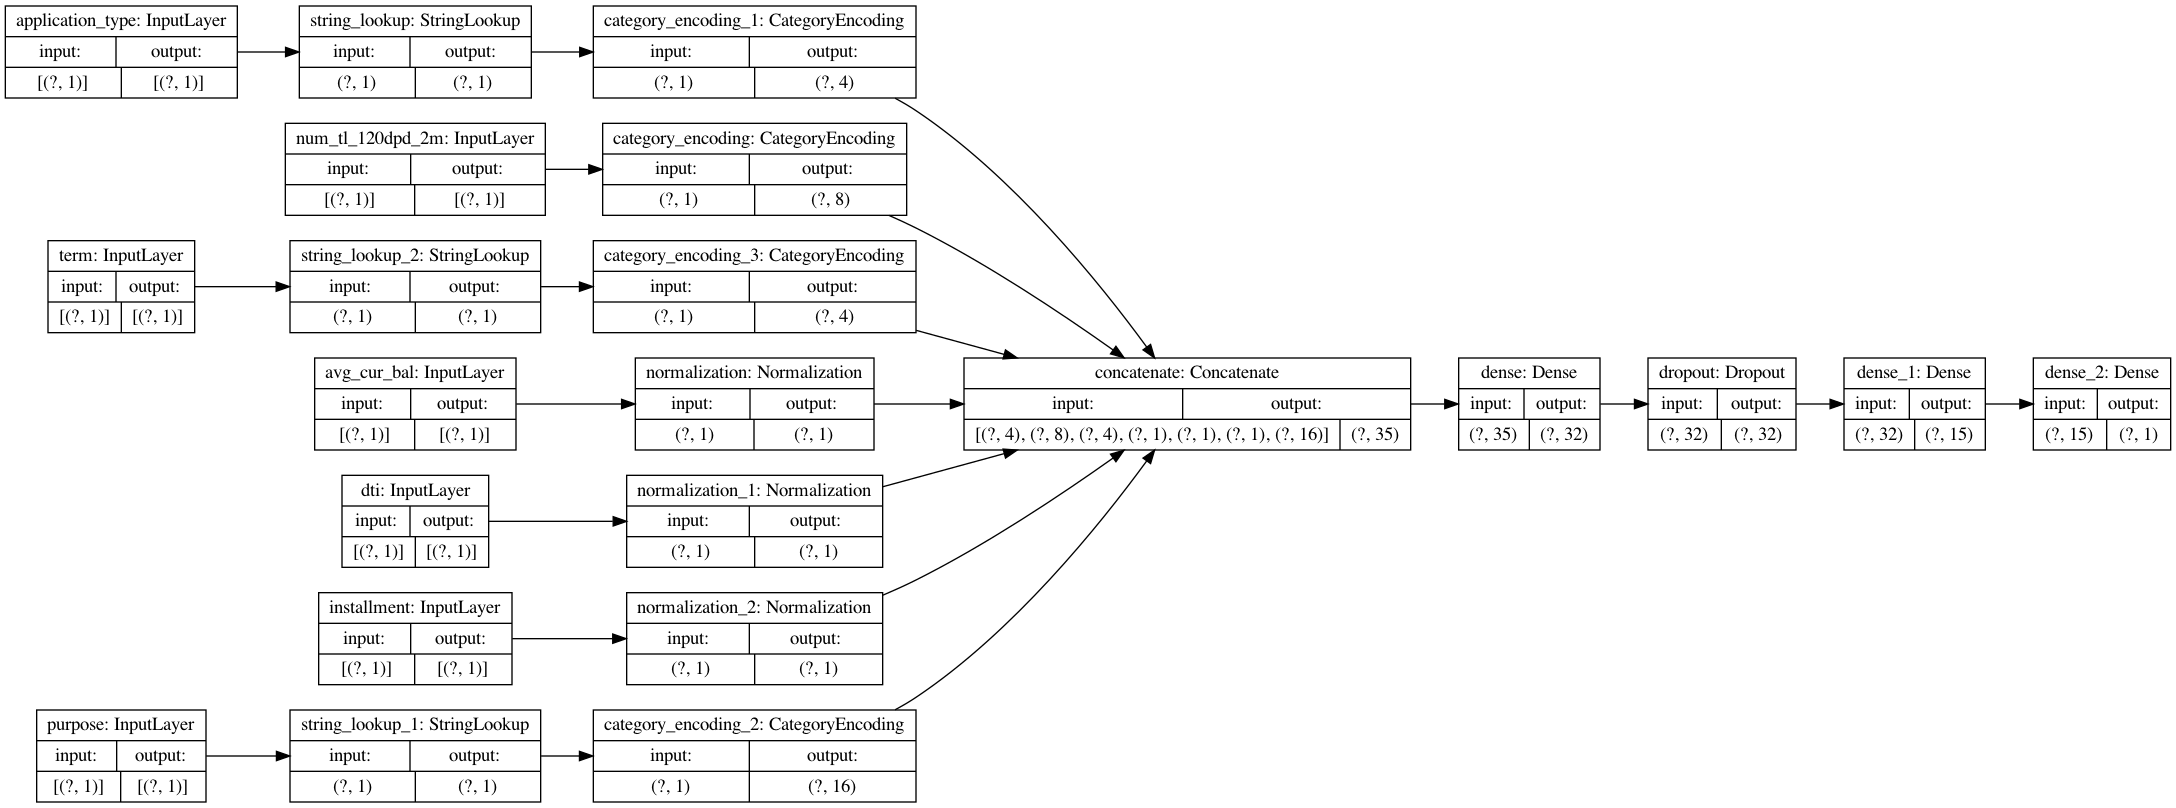

In [13]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model,to_file="model.png", show_shapes=True, rankdir="LR")

In [14]:

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
application_type (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
term (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
purpose (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup (StringLookup)    (None, 1)            0           application_type[0][0]           
_______________________________________________________________________________________

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='mnist.model.best.tf', verbose=1, save_best_only=True)

logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(train_ds, epochs=50,
          callbacks=[tensorboard_callback,checkpointer],
          validation_data=val_ds)

Epoch 1/50
29309/29314 [============================>.] - ETA: 0s - loss: 0.6191 - accuracy: 0.6545
Epoch 00001: val_loss improved from inf to 0.62675, saving model to mnist.model.best.tf
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mnist.model.best.tf/assets
29314/29314 [==============================] - 115s 4ms/step - loss: 0.6191 - accuracy: 0.6545 - val_loss: 0.6267 - val_accuracy: 0.6530
Epoch 2/50
29314/29314 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.6552
Epoch 00002: val_loss improved from 0.62675 to 0.62570, saving model to mnist.model.best.tf
INFO:tensorflow:Assets written to: mnist.model.best.tf/assets
29314/29314 [==============================] - 114s 4ms/step - loss: 0.6190 - accuracy: 0.6552 - val_loss: 0.6257 - val_accur

In [ ]:
model.save("intento-full.01-09-18-09")

In [ ]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)